Installs

In [12]:
!pip install keybert
!pip install nltk
!pip install gensim
!pip install mendelai-brat-parser
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Imports

In [13]:
from keybert import KeyBERT
import os
import gensim.downloader
from gensim.models import Word2Vec
from brat_parser import get_entities_relations_attributes_groups
import torch
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification
from sklearn.metrics import f1_score
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

Evaluation Functions

In [14]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

def accuracy(preds, labels):
  correct = 0
  for pred,label in zip(preds,labels):
    if pred == label:
      correct += 1
  return (f"{round(correct/len(labels)*100,2)}%")

Read in Files

In [15]:
#!wget -O new_data.zip https://github.com/ScienceIE/scienceie.github.io/raw/master/resources/scienceie2017_train.zip
#!unzip /content/new_data.zip

!wget -O test_data.zip https://github.com/ScienceIE/scienceie.github.io/raw/master/resources/semeval_articles_test.zip
!unzip /content/test_data.zip

--2022-06-02 15:13:14--  https://github.com/ScienceIE/scienceie.github.io/raw/master/resources/semeval_articles_test.zip
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ScienceIE/scienceie.github.io/master/resources/semeval_articles_test.zip [following]
--2022-06-02 15:13:14--  https://raw.githubusercontent.com/ScienceIE/scienceie.github.io/master/resources/semeval_articles_test.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 146325 (143K) [application/zip]
Saving to: ‘test_data.zip’

test_data.zip       100%[===================>] 142.90K  --.-KB/s    in 0.03s   

2022-06-02 15:13:15 (4.92 M

Task 1 Model

In [16]:
correct=0
total=0
kw_model = KeyBERT()
for files in os.walk("/content/train2/"):
  for smaller_file in files[2]:
    if '.txt' in smaller_file:
      if smaller_file != 'S0009261413011111.txt':
        with open(f"/content/train2/{smaller_file}") as f:
          doc = f.readlines()
        my_keywords = kw_model.extract_keywords(doc, keyphrase_ngram_range=(1, 2),
                      use_maxsum=True, nr_candidates=20, top_n=5)
        print(f"{smaller_file}")
        entities, relations, attributes, groups = get_entities_relations_attributes_groups(f"/content/train2/{os.path.splitext(smaller_file)[0]}.ann")
        values = entities.values()
        for keyword, value in zip(my_keywords,values):
          total+=1
          #print(f"{keyword[0][0]}, {value.text}")
          if keyword[0][0] in value.text or value.text in keyword[0][0]:
            correct+=1
        #print("--------------------------")
      else:
        break

correct

/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "
1it [00:00, 105.01it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0098300413002720.txt


1it [00:00, 233.86it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212671612000704.txt


1it [00:00, 272.23it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0032386110004039.txt


1it [00:00, 596.63it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370269304009359.txt


1it [00:00, 188.73it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0301010414003516.txt


1it [00:00, 194.55it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0167273814004408.txt


1it [00:00, 223.01it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0021999114002587.txt


1it [00:00, 182.40it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0032386109004996.txt


1it [00:00, 508.34it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212667814001361.txt


1it [00:00, 120.54it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212667814000070.txt


1it [00:00, 558.72it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S074756321630348X.txt


1it [00:00, 155.80it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212667814000550.txt


1it [00:00, 175.40it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0029549314002970.txt


1it [00:00, 187.36it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0165212511000862.txt


1it [00:00, 189.33it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212667814000331.txt


1it [00:00, 187.61it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0031920113001222.txt


1it [00:00, 129.12it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370269304007439.txt


1it [00:00, 192.59it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370269304006161.txt


1it [00:00, 355.06it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0021999114007396.txt


1it [00:00, 131.97it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212667814001476.txt


1it [00:00, 257.05it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S092702561300267X.txt


1it [00:00, 172.31it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0003491615001955.txt


1it [00:00, 238.18it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212667812000822.txt


1it [00:00, 301.12it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0378381215300674.txt


1it [00:00, 414.99it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0166218X1300348X.txt


1it [00:00, 401.29it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212671612002302.txt


1it [00:00, 387.04it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0010938X13002187.txt


1it [00:00, 332.88it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0032386109007290.txt


1it [00:00, 201.15it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0009261412006513.txt


1it [00:00, 633.01it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370157312000105.txt


1it [00:00, 215.78it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S025405841530136X.txt


1it [00:00, 213.83it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0032386109006612.txt


1it [00:00, 168.89it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0167931713004061.txt


1it [00:00, 763.57it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212667812000536.txt


1it [00:00, 354.25it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0378381215301291.txt


1it [00:00, 345.47it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0032386109005485.txt


1it [00:00, 216.17it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2214657115000155.txt


1it [00:00, 194.89it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370269304007749.txt


1it [00:00, 170.07it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S1570870516301822.txt


1it [00:00, 172.51it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0377221716304258.txt


1it [00:00, 173.28it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0010938X14000420.txt


1it [00:00, 683.89it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370269304009220.txt


1it [00:00, 315.43it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0009261415002730.txt


1it [00:00, 327.48it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0167931712003012.txt


1it [00:00, 152.51it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0167931712002699.txt


1it [00:00, 379.09it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370269304007798.txt


1it [00:00, 396.89it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0393044012000198.txt


1it [00:00, 379.16it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S016793171300244X.txt


1it [00:00, 190.25it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0888613X16301062.txt


1it [00:00, 360.46it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212671612002338.txt


1it [00:00, 252.55it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0375960112002885.txt


1it [00:00, 331.25it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0022311515002664.txt


1it [00:00, 137.53it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212671612001291.txt


1it [00:00, 161.99it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0039602899010869.txt


1it [00:00, 401.71it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0021999114007876.txt


1it [00:00, 192.79it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212671612001709.txt


1it [00:00, 223.62it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212667814000884.txt


1it [00:00, 191.17it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0021999114008432.txt


1it [00:00, 183.29it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0045782512002678.txt


1it [00:00, 215.03it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0168365913009036.txt


1it [00:00, 162.37it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212671612000698.txt


1it [00:00, 279.75it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0022311515300295.txt


1it [00:00, 214.83it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S1566253516300069.txt


1it [00:00, 234.36it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0045782515002686.txt


1it [00:00, 118.32it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0045782513000546.txt


1it [00:00, 262.92it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2214509515300103.txt


1it [00:00, 286.24it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S003238610801080X.txt


1it [00:00, 325.06it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0038092X15000559.txt


1it [00:00, 256.42it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0022311514000919.txt


1it [00:00, 161.13it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370269304006756.txt


1it [00:00, 293.76it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370269304009232.txt


1it [00:00, 329.79it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212667812000883.txt


1it [00:00, 142.78it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212667812000524.txt


1it [00:00, 356.05it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370269304009141.txt


1it [00:00, 140.59it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0038092X15001681.txt


1it [00:00, 126.98it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212671612001163.txt


1it [00:00, 145.21it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0895611116300684.txt


1it [00:00, 247.95it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370157314001318.txt


1it [00:00, 272.04it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0045782514000607.txt


1it [00:00, 248.32it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2214657115000052.txt


1it [00:00, 159.56it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0045782514001492.txt


1it [00:00, 171.27it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370269304008305.txt


1it [00:00, 205.10it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0167931714004456.txt


1it [00:00, 358.21it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370269304006720.txt


1it [00:00, 297.72it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0010938X12001163.txt


1it [00:00, 167.86it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0022311513001165.txt


1it [00:00, 359.16it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0167273811005091.txt


1it [00:00, 247.54it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0009261412012365.txt


1it [00:00, 163.32it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0375960115005630.txt


1it [00:00, 133.68it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0168365913003295.txt


1it [00:00, 145.29it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S221450951530005X.txt


1it [00:00, 211.37it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S221266781400080X.txt


1it [00:00, 256.72it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0045782513001448.txt


1it [00:00, 280.84it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0003491615001505.txt


1it [00:00, 166.26it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212667813001068.txt


1it [00:00, 127.83it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0375960113006725.txt


1it [00:00, 263.00it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370269304009530.txt


1it [00:00, 284.71it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0166218X14003011.txt


1it [00:00, 139.98it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S1361841516300822.txt


1it [00:00, 121.38it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0165168416300603.txt


1it [00:00, 704.93it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S221267161200162X.txt


1it [00:00, 140.79it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370269304008731.txt


1it [00:00, 186.11it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0098300412001793.txt


1it [00:00, 384.02it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212667814000045.txt


1it [00:00, 235.46it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0010938X1530161X.txt


1it [00:00, 280.46it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0168365912006207.txt


1it [00:00, 244.10it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0167931714000203.txt


1it [00:00, 169.84it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0885230816300043.txt


1it [00:00, 140.08it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0167931713002487.txt


1it [00:00, 397.53it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0098300413002185.txt


1it [00:00, 129.11it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0021999115001412.txt


1it [00:00, 157.15it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0021999115008256.txt


1it [00:00, 176.52it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370269304007634.txt


1it [00:00, 165.57it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212667812000664.txt


1it [00:00, 115.78it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0375960113004908.txt


1it [00:00, 340.03it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S221266781400121X.txt


1it [00:00, 266.68it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S1364815216303541.txt


1it [00:00, 677.81it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212667813000762.txt


1it [00:00, 235.56it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0301010415002256.txt


1it [00:00, 579.96it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S037596011300741X.txt


1it [00:00, 149.77it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0022311513011951.txt


1it [00:00, 151.53it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0254058415001212.txt


1it [00:00, 253.86it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0301932215002037.txt


1it [00:00, 381.16it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370269304009049.txt


1it [00:00, 142.62it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S088523081530036X.txt


1it [00:00, 167.16it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0167931713002438.txt


1it [00:00, 166.83it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212667814000756.txt


1it [00:00, 165.07it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212671612002181.txt


1it [00:00, 218.86it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S221266781200007X.txt


1it [00:00, 224.61it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0031920113000708.txt


1it [00:00, 199.24it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0032386108010392.txt


1it [00:00, 376.88it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0010938X12002508.txt


1it [00:00, 159.49it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0167931713006904.txt


1it [00:00, 288.07it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0010938X13005945.txt


1it [00:00, 205.90it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0377221716303873.txt


1it [00:00, 135.30it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0377025714001682.txt


1it [00:00, 147.44it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0022311514008691.txt


1it [00:00, 341.89it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212667813000610.txt


1it [00:00, 601.16it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0306437913000768.txt


1it [00:00, 245.64it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S1875952116300209.txt


1it [00:00, 298.68it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S000926141500651X.txt


1it [00:00, 253.36it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0022311515300830.txt


1it [00:00, 182.89it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0305054816300867.txt


1it [00:00, 617.81it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0022311511010014.txt


1it [00:00, 447.11it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0165212515000931.txt


1it [00:00, 158.44it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0736585316300661.txt


1it [00:00, 152.59it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S221267161200176X.txt


1it [00:00, 261.98it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0021999114008523.txt


1it [00:00, 161.99it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0029549314001551.txt


1it [00:00, 228.42it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0377221716300984.txt


1it [00:00, 350.64it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S000926141301539X.txt


1it [00:00, 170.98it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370269304007701.txt


1it [00:00, 293.39it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0377025714000317.txt


1it [00:00, 162.97it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212671612002375.txt


1it [00:00, 144.25it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0022311515300477.txt


1it [00:00, 172.99it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0377221716301904.txt


1it [00:00, 163.25it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0010938X15301189.txt


1it [00:00, 155.72it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370269304008792.txt


1it [00:00, 154.09it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0167273815004130.txt


1it [00:00, 557.31it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0957417416303773.txt


1it [00:00, 247.66it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0021961413004321.txt


1it [00:00, 148.14it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0045782513000479.txt


1it [00:00, 232.44it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0266352X16301550.txt


1it [00:00, 527.59it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370157309002877.txt


1it [00:00, 273.08it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0022311515301963.txt


1it [00:00, 396.14it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370269304009013.txt


1it [00:00, 129.84it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0957417416302561.txt


1it [00:00, 357.39it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0927025614007137.txt


1it [00:00, 154.16it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370269304009104.txt


1it [00:00, 314.77it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0142061516308079.txt


1it [00:00, 151.52it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0377025715000993.txt


1it [00:00, 137.61it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0045782512000266.txt


1it [00:00, 419.22it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212671612001692.txt


1it [00:00, 122.12it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S1361841516300342.txt


1it [00:00, 207.63it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212667814001294.txt


1it [00:00, 115.36it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370269304009347.txt


1it [00:00, 398.32it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370269304009074.txt


1it [00:00, 180.75it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0021999113005652.txt


1it [00:00, 146.99it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0963869514000863.txt


1it [00:00, 141.58it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0021999115000546.txt


1it [00:00, 145.98it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0010938X15002085.txt


1it [00:00, 348.42it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0375960113010839.txt


1it [00:00, 295.39it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0045782512003428.txt


1it [00:00, 422.43it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0167931711005120.txt


1it [00:00, 140.43it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370269304009979.txt


1it [00:00, 337.33it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212667813000774.txt


1it [00:00, 198.93it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0377025715000051.txt


1it [00:00, 657.93it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370269304009657.txt


1it [00:00, 117.45it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0010938X1500195X.txt


1it [00:00, 210.81it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0045782513001473.txt


1it [00:00, 93.26it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370269304007208.txt


1it [00:00, 208.21it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0032386114008428.txt


1it [00:00, 547.27it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0032386109001712.txt


1it [00:00, 240.49it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212667812000792.txt


1it [00:00, 173.53it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0045782512003234.txt


1it [00:00, 397.68it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370269304009037.txt


1it [00:00, 183.38it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0021999115007238.txt


1it [00:00, 203.14it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0377221716302259.txt


1it [00:00, 122.06it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0038092X14004770.txt


1it [00:00, 329.04it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370269304009165.txt


1it [00:00, 218.25it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370269304009335.txt


1it [00:00, 185.83it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370269304009268.txt


1it [00:00, 411.77it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0957417416301786.txt


1it [00:00, 122.44it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0167931713004991.txt


1it [00:00, 142.99it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0167931714003347.txt


1it [00:00, 368.24it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0032386109010386.txt


1it [00:00, 150.10it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0379711213001653.txt


1it [00:00, 147.71it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S037026930400930X.txt


1it [00:00, 158.40it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212671612000121.txt


1it [00:00, 144.34it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0021999113005603.txt


1it [00:00, 133.57it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0021999113003422.txt


1it [00:00, 416.80it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0888327016300048.txt


1it [00:00, 181.53it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0022311515301069.txt


1it [00:00, 175.93it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0022311514007119.txt


1it [00:00, 151.20it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370269304008809.txt


1it [00:00, 228.31it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0167931713005042.txt


1it [00:00, 154.32it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212667812000780.txt


1it [00:00, 169.32it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0038092X11004129.txt


1it [00:00, 145.28it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0022311514006849.txt


1it [00:00, 341.42it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0098300413002951.txt


1it [00:00, 146.44it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0022311515303640.txt


1it [00:00, 139.32it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0377221716301357.txt


1it [00:00, 258.75it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0045782515002418.txt


1it [00:00, 139.87it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0010938X15002954.txt


1it [00:00, 174.02it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0254058414000662.txt


1it [00:00, 145.82it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0009261413006738.txt


1it [00:00, 133.54it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370269304008998.txt


1it [00:00, 263.88it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212667814000264.txt


1it [00:00, 134.41it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0168365913004975.txt


1it [00:00, 262.95it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212667814001348.txt


1it [00:00, 454.37it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0997754612001318.txt


1it [00:00, 290.04it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212667814000732.txt


1it [00:00, 295.98it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0377025714000135.txt


1it [00:00, 199.13it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0377025713001031.txt


1it [00:00, 196.78it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0168874X1630049X.txt


1it [00:00, 157.59it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212667812000810.txt


1it [00:00, 221.71it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S002231151500032X.txt


1it [00:00, 152.35it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S092702561300760X.txt


1it [00:00, 149.09it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212667812000032.txt


1it [00:00, 173.08it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370269304009062.txt


1it [00:00, 132.63it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0168365913008766.txt


1it [00:00, 131.55it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370269304007695.txt


1it [00:00, 420.78it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0021999115003939.txt


1it [00:00, 182.81it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370269304008780.txt


1it [00:00, 223.89it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S221266781300083X.txt


1it [00:00, 167.32it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2352179114200032.txt


1it [00:00, 155.34it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212667814000124.txt


1it [00:00, 156.96it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212667812000949.txt


1it [00:00, 121.88it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212667814000975.txt


1it [00:00, 149.34it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212667814001464.txt


1it [00:00, 148.86it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370269304009803.txt


1it [00:00, 441.78it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212667814001488.txt


1it [00:00, 434.24it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S221267161200217X.txt


1it [00:00, 137.94it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0167931712003905.txt


1it [00:00, 315.27it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370269304006082.txt


1it [00:00, 186.75it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0009261415000974.txt


1it [00:00, 135.88it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0022311514001640.txt


1it [00:00, 139.78it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370269304009116.txt


1it [00:00, 103.88it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370269304008706.txt


1it [00:00, 185.22it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0045782515001899.txt


1it [00:00, 421.28it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370269304009086.txt


1it [00:00, 146.05it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0021999113005718.txt


1it [00:00, 135.54it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0022311514005480.txt


1it [00:00, 110.30it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370269304006768.txt


1it [00:00, 142.48it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0377025714002213.txt


1it [00:00, 347.84it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0749603615302184.txt


1it [00:00, 309.59it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S037026930400680X.txt


1it [00:00, 227.74it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0021999115008207.txt


1it [00:00, 383.43it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S221266781300018X.txt


1it [00:00, 238.10it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370269304009189.txt


1it [00:00, 220.97it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0022311515002391.txt


1it [00:00, 175.52it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0010938X15300512.txt


1it [00:00, 117.69it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S221266781400149X.txt


1it [00:00, 210.72it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370269304007257.txt


1it [00:00, 213.23it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0167273814004548.txt


1it [00:00, 288.21it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0022311515002470.txt


1it [00:00, 152.25it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370269304006070.txt


1it [00:00, 204.79it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0167273813006735.txt


1it [00:00, 150.43it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0045782512002599.txt


1it [00:00, 267.14it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212667814001440.txt


1it [00:00, 155.69it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0045782515003680.txt


1it [00:00, 482.71it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0888613X16300767.txt


1it [00:00, 159.22it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0301010414003115.txt


1it [00:00, 221.93it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370269304008858.txt


1it [00:00, 218.86it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0021999115003459.txt


1it [00:00, 719.31it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212671612001497.txt


1it [00:00, 128.07it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0301932214001499.txt


1it [00:00, 140.55it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S003238610900086X.txt


1it [00:00, 156.40it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0045782511003823.txt


1it [00:00, 179.37it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212671612000686.txt


1it [00:00, 361.14it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212671612000716.txt


1it [00:00, 136.39it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212667814000069.txt


1it [00:00, 111.81it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S004578251400334X.txt


1it [00:00, 225.20it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0927025612000249.txt


1it [00:00, 133.28it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212671612001618.txt


1it [00:00, 376.00it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212667814000380.txt


1it [00:00, 180.45it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370269304009025.txt


1it [00:00, 138.62it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0079642514000887.txt


1it [00:00, 153.28it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212671612000637.txt


1it [00:00, 332.22it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212671612002120.txt


1it [00:00, 157.82it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0009261412013838.txt


1it [00:00, 294.67it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S2212671612002351.txt


1it [00:00, 131.40it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0370269304008974.txt


1it [00:00, 398.36it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0045782514004812.txt


1it [00:00, 129.53it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0003491615000433.txt


1it [00:00, 189.57it/s]
/usr/local/lib/python3.7/dist-packages/keybert/_model.py:131: UserWarning: Although extracting keywords for multiple documents is faster than iterating over single documents, it requires significantly more memory to hold all word embeddings. Use this at your own discretion!
  "Although extracting keywords for multiple documents is faster "


S0167273812003025.txt


1it [00:00, 180.92it/s]

S0032386109007423.txt


21

Task 1 Evaluation

In [17]:
print(correct)
print(total)
my_accuracy = correct/total
print(f"Accuracy = {round(my_accuracy*100,2)}%")

21
307
Accuracy = 6.84%


Task 2 Glove Embeddings

In [18]:
sentences = []
my_vectors = []
my_keys = []

glove_vectors = gensim.downloader.load('glove-twitter-25')

for files in os.walk("/content/train2/"):
  for smaller_file in files[2]:
    if '.ann' in smaller_file:
      if smaller_file != 'S0045782515001231.ann':
        print(smaller_file)
        entities, relations, attributes, groups = get_entities_relations_attributes_groups(f"/content/train2/{smaller_file}")
        keys = entities.keys()
        values = entities.values()
        for key,value in zip(keys, values):
          if value.text not in glove_vectors.wv:
            vector = glove_vectors.wv['unk']
          else:
            vector = glove_vectors.wv[value.text]
            #count = count+1
          my_keys.append(value.type)
          my_vectors.append(vector)
      else:
        break

S0029549314001551.ann
S2212667814000987.ann
S2212667814000951.ann
S0167273812003025.ann
S0098300413002185.ann
S0370269304007208.ann
S0009261409006666.ann
S0167931714000203.ann
S0370269304007695.ann
S0888613X16300767.ann
S0168874X1630049X.ann
S2212667813000762.ann
S0003491615000433.ann
S0010938X15300512.ann
S221450951530005X.ann
S0370269304009141.ann
S0370269304008998.ann
S2212671612002338.ann
S0167931714003347.ann
S0370269304006768.ann
S0022311514007119.ann
S0167931714004456.ann
S0167273813005298.ann
S2212667814001348.ann
S0370269304007439.ann
S0377025714000317.ann
S2212667812000937.ann
S037026930400930X.ann
S0032386109007423.ann
S0022311515002664.ann
S0377221716300984.ann
S0022311515301963.ann
S0370269304007701.ann
S0168365913004975.ann
S0045782513000479.ann
S0045782513001448.ann
S2212671612000613.ann
S0022311515300477.ann
S0021999114008432.ann
S0370269304009165.ann
S0377221716302259.ann
S2212667813000774.ann
S0370269304009803.ann
S0305054816300867.ann
S0370269304007257.ann
S030193221

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


Task 2 Bert Embeddings

In [19]:
sentences = []
my_vectors = []
my_keys = []

model = SentenceTransformer('all-MiniLM-L6-v2')

for files in os.walk("/content/train2/"):
  for smaller_file in files[2]:
    if '.ann' in smaller_file:
      if smaller_file != 'S0045782515001231.ann':
        entities, relations, attributes, groups = get_entities_relations_attributes_groups(f"/content/train2/{smaller_file}")
        keys = entities.keys()
        values = entities.values()
        for key,value in zip(keys, values):
          if value.text not in glove_vectors.wv:
            vector = model.encode('unk')
          else:
            vector = model.encode(value.text)

          my_keys.append(value.type)
          my_vectors.append(vector)
      else:
        break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  from ipykernel import kernelapp as app


Get Baseline

Support Vector Classifier

In [20]:
X = my_vectors
y = my_keys

# dividing X, y into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

preds = OneVsOneClassifier(LinearSVC(random_state=0)).fit(X, y).predict(X)

my_accuracy = accuracy(preds, my_keys)

print(f"Task 2 Support Vector Classifier Accuracy = {my_accuracy}")

my_f1_score = f1_score(y, preds, average='micro')
print(f"Task 2 Base F1 Score = {round(my_f1_score*100,2)}")

Task 2 Support Vector Classifier Accuracy = 52.1%
Task 2 Base F1 Score = 52.1


In [21]:
base_preds = []
for _ in preds:
  base_preds.append("Material")

base_accuracy = accuracy(base_preds, my_keys)
my_f1_score = f1_score(y, base_preds, average='micro')
print(f"Task 2 Base F1 Score = {round(my_f1_score,2)}")

Task 2 Base F1 Score = 0.38


Decision Tree Classifier

In [22]:
dtree_model = DecisionTreeClassifier(max_depth = 2).fit(X, y)
dtree_predictions = dtree_model.predict(X)

dtree_accuracy = accuracy(dtree_predictions, my_keys)

my_f1_score = f1_score(y, dtree_predictions, average='micro')
print(f"Task 2 Decision Tree F1 Score = {round(my_f1_score*100,2)}")

Task 2 Decision Tree F1 Score = 49.27


Confusion Matrices

In [23]:
matrix = confusion_matrix(y, preds)
matrix.diagonal()/matrix.sum(axis=1)

matrix

array([[ 68, 299,   0],
       [  0, 424,   0],
       [  0, 158,   5]])

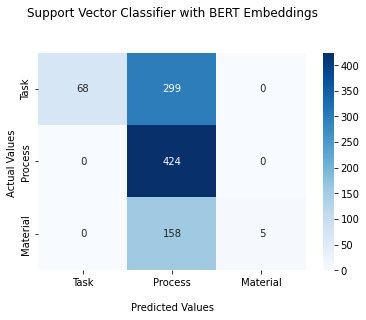

In [ ]:
ax = sns.heatmap(matrix, annot=True, fmt='2', cmap='Blues')

ax.set_title('Support Vector Classifier with BERT Embeddings\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Task','Process', 'Material'])
ax.yaxis.set_ticklabels(['Task','Process', 'Material'])

## Display the visualization of the Confusion Matrix.
plt.show()